In [ ]:
# General utilities
import warnings  # Module to handle warnings
from typing import Any, Optional, Tuple  # Modules for type hinting
import getpass  # Module to securely handle password prompts

# Plotting
import geopandas as gpd  # Module for working with geospatial data
import matplotlib.patches as mpatches  # Module for creating custom patches in plots
import matplotlib.pyplot as plt  # Module for creating plots and visualizations
import numpy as np  # Module for numerical operations

# Sentinel Hub services
from sentinelhub import (
    CRS,  # Module for handling coordinate reference systems
    DataCollection,  # Module for accessing different data collections
    Geometry,  # Module for handling geometric shapes
    MimeType,  # Module for handling different MIME types
    SentinelHubRequest,  # Module for creating requests to Sentinel Hub services
    SHConfig,  # Module for configuring Sentinel Hub settings
)
from shapely.geometry import shape  # Module for handling geometric shapes

# Ignore warnings
warnings.filterwarnings("ignore")

# Enable inline plotting in Jupyter notebooks
%matplotlib inline

In [ ]:
def plot_image(
    image: np.ndarray,
    factor: float = 1.0,
    clip_range: Optional[Tuple[float, float]] = None,
    **kwargs: Any
) -> None:
    """
    Utility function for plotting RGB images.
    
    Parameters:
    - image (np.ndarray): The image to be plotted, expected to be a NumPy array.
    - factor (float): A scaling factor to adjust the image intensity. Default is 1.0.
    - clip_range (Optional[Tuple[float, float]]): A range to clip the image values for better visualization. Default is None.
    - **kwargs (Any): Additional keyword arguments to pass to the imshow function.
    
    This function creates a plot of the given RGB image using Matplotlib. It scales the image by the given factor and optionally clips the image values to the specified range for better visualization. The plot is displayed without axis ticks.
    """
    
    # Create a figure and axis for plotting
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    
    # If a clipping range is provided, clip the image values and plot
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        # Otherwise, plot the scaled image without clipping
        ax.imshow(image * factor, **kwargs)
    
    # Remove axis ticks for a cleaner visualization
    ax.set_xticks([])
    ax.set_yticks([])

In [ ]:
# Only run this cell if you have not created a configuration.

# Create a new Sentinel Hub configuration object
config = SHConfig()

# Prompt the user to enter their SentinelHub client ID securely
config.sh_client_id = getpass.getpass("Enter your SentinelHub client id")

# Prompt the user to enter their SentinelHub client secret securely
config.sh_client_secret = getpass.getpass("Enter your SentinelHub client secret")

# Set the token URL for authentication with Copernicus Data Space Ecosystem
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"

# Set the base URL for accessing Sentinel Hub services in Copernicus Data Space Ecosystem
config.sh_base_url = "https://sh.dataspace.copernicus.eu"

# Save the configuration with the name "cdse"
config.save("cdse")

# Load the saved configuration named "cdse"
config = SHConfig("cdse")


In [ ]:
# Define the area of interest as a GeoJSON string
area_of_interest = """
{
  "type": "Polygon",
  "coordinates": [
    [
      [
        8.2000,
        39.6000
      ],
      [
        8.9000,
        39.6000
      ],
      [
        8.9000,
        40.1000
      ],
      [
        8.2000,
        40.1000
      ],
      [
        8.2000,
        39.6000
      ]
    ]
  ]
}
"""

# Read the area of interest into a GeoDataFrame
aoi = gpd.read_file(area_of_interest)

# Set the geometry column to the area of interest
aoi["geometry"] = aoi

# Calculate the area of the geometry and store it in a new column
aoi["area"] = aoi.area

# Explore the area of interest, coloring it green and without a legend
aoi.explore("area", color="Green", legend=False)

In [ ]:
# Convert the area of interest (aoi) to the coordinate reference system (CRS) with EPSG code 32630 (UTM zone 30N)
# and create a Geometry object with the converted geometry and the specified CRS.
full_geometry = Geometry(aoi.to_crs(32630).geometry.values[0], crs=CRS.UTM_30N)

In [ ]:
# Define the evalscript for fire detection using Sentinel-3 SLSTR data
evalscript_fire_detection = """
// High accuracy detection of active fire points
// Sentinel-3 SLSTR
// by Tiznger startup co
// www.tiznegar.com

// Calculate the SAHM index using bands S6 and S5
var SAHM = ((S6 - S5) / (S6 + S5));

// If the SAHM index is greater than 0.05 and band S1 is less than 0.23,
// return a combination of bands S3, S2, and S1 with enhanced red color for fire detection
if (SAHM > 0.05 && S1 < 0.23) {
  return [5 * S3, 1 * S2, 1 * S1];
}

// Otherwise, return a combination of bands S6, S3, and S2 for normal visualization
else {
  return [S6, S3, S2];
}

// Red color indicates active fire areas and points
"""

In [ ]:
# Create a SentinelHubRequest object for true color imagery using the fire detection evalscript
request_true_color = SentinelHubRequest(
    evalscript=evalscript_fire_detection,  # Use the fire detection evalscript
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL3_SLSTR.define_from(
                name="s3",  # Define the data collection as Sentinel-3 SLSTR
                service_url="https://sh.dataspace.copernicus.eu"  # Set the service URL for Copernicus Data Space Ecosystem
            ),
            time_interval=("2021-07-30", "2021-07-30"),  # Set the time interval for the data request
            other_args={"dataFilter": {"mosaickingOrder": "leastRecent"}},  # Set additional arguments for data filtering
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],  # Define the response format as PNG
    geometry=full_geometry,  # Set the geometry for the area of interest
    size=[1000, 920],  # Set the size of the requested image
    config=config,  # Use the previously defined configuration
)

In [ ]:
# Execute the request to retrieve the true color images using the fire detection evalscript
true_color_imgs = request_true_color.get_data()

In [ ]:
# Print the type and length of the returned data
print(
    f"Returned data is of type = {type(true_color_imgs)} and length {len(true_color_imgs)}."
)

# Print the type and shape of a single element in the returned data list
print(
    f"Single element in the list is of type {type(true_color_imgs[-1])} and has shape {true_color_imgs[-1].shape}"
)

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (920, 1000, 3)


Image type: uint8


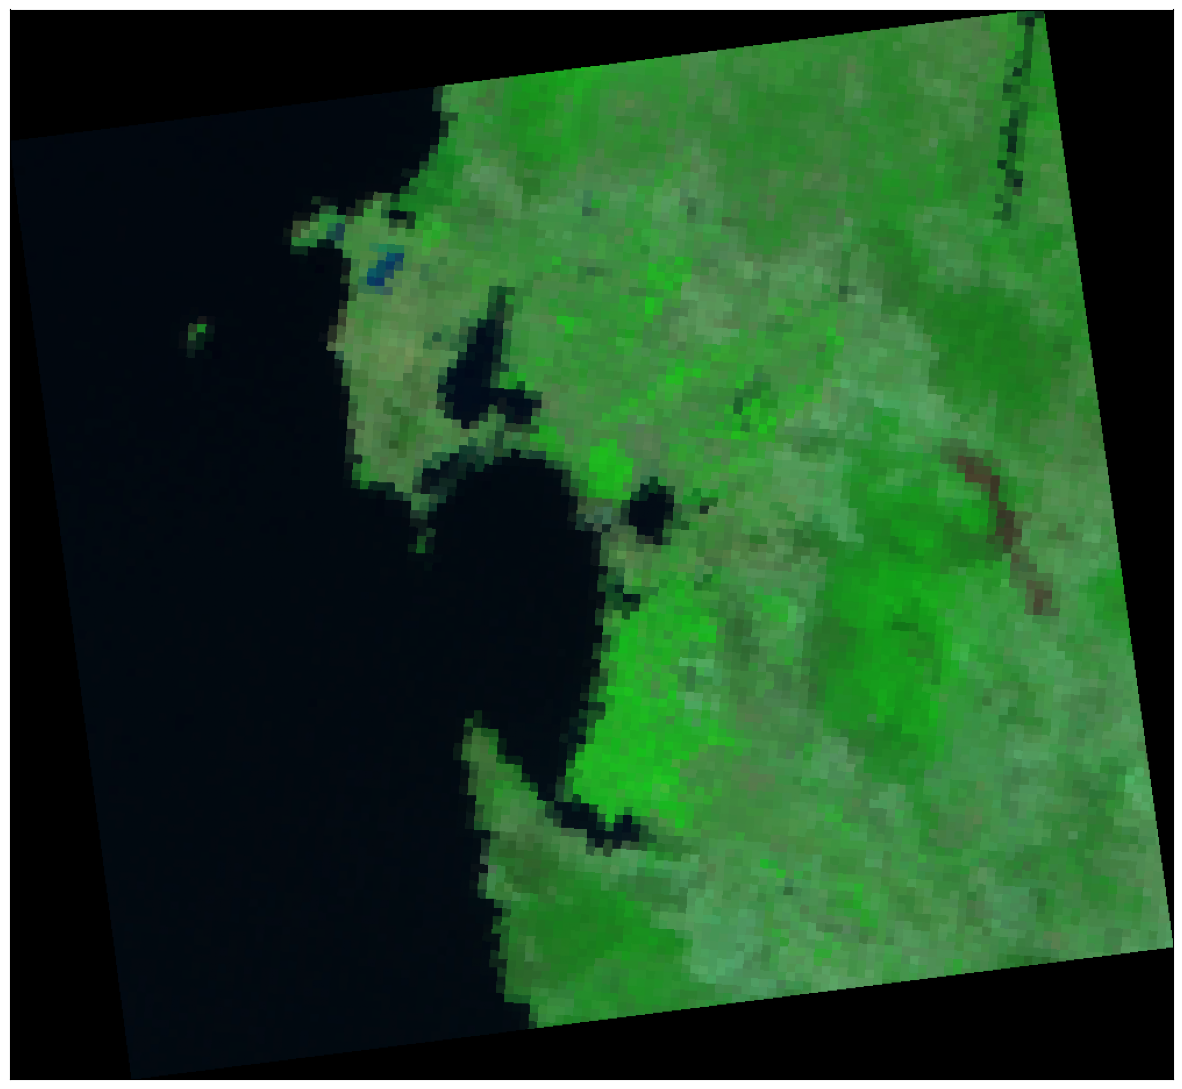

In [ ]:
# Select the first image from the returned true color images
image = true_color_imgs[0]

# Print the data type of the selected image
print(f"Image type: {image.dtype}")

# Plot the selected image using the plot_image function
# The factor parameter scales the image intensity, and clip_range specifies the range for clipping the image values
plot_image(image, factor=1.5 / 255, clip_range=(0, 1))

In [ ]:
evalscript_wildfire_visualisation = """
// VERSION=3
// QuickFire V1.0.0 by Pierre Markuse (https://twitter.com/Pierre_Markuse)
// Adjusted for use in the Copernicus Browser (https://dataspace.copernicus.eu/browser/)
// CC BY 4.0 International (https://creativecommons.org/licenses/by/4.0/)

// Copernicus Browser does not have the band CLP, this was replaced with the isCloud() function
// but do try to turn off cloudAvoidance if results aren't as expected.

function setup() {
    return {
        input: ["B02", "B03", "B04", "B08", "B8A", "B11", "B12", "dataMask"],
        output: { bands: 4 }
    };
}

// Function to determine if a pixel is a cloud
function isCloud(samples) {
    const NGDR = index(samples.B03, samples.B04);
    const bRatio = (samples.B03 - 0.175) / (0.39 - 0.175);
    return bRatio > 1 || (bRatio > 0 && NGDR > 0);
}

// Function to stretch values for visualization
function stretch(val, min, max) { return (val - min) / (max - min); }

// Function to enhance saturation
function satEnh(arr, s) {
    var avg = arr.reduce((a, b) => a + b, 0) / arr.length;
    return arr.map(a => avg * (1 - s) + a * s);
}

// Function to blend layers for visualization
function layerBlend(lay1, lay2, lay3, op1, op2, op3) {
    return lay1.map(function (num, index) {
        return (num / 100 * op1 + (lay2[index] / 100 * op2) + (lay3[index] / 100 * op3));
    });
}

// Main function to evaluate each pixel
function evaluatePixel(sample) {
    const hsThreshold = [2.0, 1.5, 1.25, 1.0];
    const hotspot = 1;
    const style = 1;
    const hsSensitivity = 1.0;
    const boost = 1.2;

    const cloudAvoidance = 1;
    const avoidanceHelper = 0.8;

    const offset = -0.007;
    const saturation = 1.10;
    const brightness = 1.40;
    const sMin = 0.15;
    const sMax = 0.99;

    const showBurnscars = 0;
    const burnscarThreshold = -0.25;
    const burnscarStrength = 0.3;

    const NDWI = (sample.B03 - sample.B08) / (sample.B03 + sample.B08);
    const NDVI = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);
    const waterHighlight = 0;
    const waterBoost = 2.0;
    const NDVI_threshold = 0.05;
    const NDWI_threshold = 0.0;
    const waterHelper = 0.1;

    const Black = [0, 0, 0];
    const NBRindex = (sample.B08 - sample.B12) / (sample.B08 + sample.B12);
    const naturalColorsCC = [Math.sqrt(brightness * sample.B04 + offset), Math.sqrt(brightness * sample.B03 + offset), Math.sqrt(brightness * sample.B02 + offset)];
    const naturalColors = [(2.5 * brightness * sample.B04 + offset), (2.5 * brightness * sample.B03 + offset), (2.5 * brightness * sample.B02 + offset)];
    const URBAN = [Math.sqrt(brightness * sample.B12 * 1.2 + offset), Math.sqrt(brightness * sample.B11 * 1.4 + offset), Math.sqrt(brightness * sample.B04 + offset)];
    const SWIR = [Math.sqrt(brightness * sample.B12 + offset), Math.sqrt(brightness * sample.B8A + offset), Math.sqrt(brightness * sample.B04 + offset)];
    const NIRblue = colorBlend(sample.B08, [0, 0.25, 1], [[0 / 255, 0 / 255, 0 / 255], [0 / 255, 100 / 255, 175 / 255], [150 / 255, 230 / 255, 255 / 255]]);
    const classicFalse = [sample.B08 * brightness, sample.B04 * brightness, sample.B03 * brightness];
    const NIR = [sample.B08 * brightness, sample.B08 * brightness, sample.B08 * brightness];
    const atmoPen = [sample.B12 * brightness, sample.B11 * brightness, sample.B08 * brightness];
    var enhNaturalColors = [0, 0, 0];
    for (let i = 0; i < 3; i += 1) { enhNaturalColors[i] = (brightness * ((naturalColors[i] + naturalColorsCC[i]) / 2) + (URBAN[i] / 10)); }

    const manualCorrection = [0.04, 0.00, -0.05];

    var Viz = layerBlend(URBAN, SWIR, naturalColorsCC, 10, 10, 90); // Choose visualization(s) and opacity here

    if (waterHighlight) {
        if ((NDVI < NDVI_threshold) && (NDWI > NDWI_threshold) && (sample.B04 < waterHelper)) {
            Viz[1] = Viz[1] * 1.2 * waterBoost + 0.1;
            Viz[2] = Viz[2] * 1.5 * waterBoost + 0.2;
        }
    }

    Viz = satEnh(Viz, saturation);
    for (let i = 0; i < 3; i += 1) {
        Viz[i] = stretch(Viz[i], sMin, sMax);
        Viz[i] += manualCorrection[i];
    }

    if (hotspot) {
        if ((!cloudAvoidance) || (!isCloud(sample) && (sample.B02 < avoidanceHelper))) {
            switch (style) {
                case 1:
                    if ((sample.B12 + sample.B11) > (hsThreshold[0] / hsSensitivity)) return [((boost * 0.50 * sample.B12) + Viz[0]), ((boost * 0.50 * sample.B11) + Viz[1]), Viz[2], sample.dataMask];
                    if ((sample.B12 + sample.B11) > (hsThreshold[1] / hsSensitivity)) return [((boost * 0.50 * sample.B12) + Viz[0]), ((boost * 0.20 * sample.B11) + Viz[1]), Viz[2], sample.dataMask];
                    if ((sample.B12 + sample.B11) > (hsThreshold[2] / hsSensitivity)) return [((boost * 0.50 * sample.B12) + Viz[0]), ((boost * 0.10 * sample.B11) + Viz[1]), Viz[2], sample.dataMask];
                    if ((sample.B12 + sample.B11) > (hsThreshold[3] / hsSensitivity)) return [((boost * 0.50 * sample.B12) + Viz[0]), ((boost * 0.00 * sample.B11) + Viz[1]), Viz[2], sample.dataMask];
                    break;
                case 2:
                    if ((sample.B12 + sample.B11) > (hsThreshold[3] / hsSensitivity)) return [1, 0, 0, sample.dataMask];
                    break;
                case 3:
                    if ((sample.B12 + sample.B11) > (hsThreshold[3] / hsSensitivity)) return [1, 1, 0, sample.dataMask];
                    break;
                case 4:
                    if ((sample.B12 + sample.B11) > (hsThreshold[3] / hsSensitivity)) return [Viz[0] + 0.2, Viz[1] - 0.2, Viz[2] - 0.2, sample.dataMask];
                    break;
                default:
            }
        }
    }

    if (showBurnscars) {
        if (NBRindex < burnscarThreshold) {
            Viz[0] = Viz[0] + burnscarStrength;
            Viz[1] = Viz[1] + burnscarStrength;
        }
    }

    return [Viz[0], Viz[1], Viz[2], sample.dataMask];
}
"""

In [ ]:
# Create a SentinelHubRequest object for wildfire visualization using the wildfire visualization evalscript
request_wildfire_visualisation = SentinelHubRequest(
    evalscript=evalscript_wildfire_visualisation,  # Use the wildfire visualization evalscript
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A.define_from(
                name="s2",  # Define the data collection as Sentinel-2 L2A
                service_url="https://sh.dataspace.copernicus.eu"  # Set the service URL for Copernicus Data Space Ecosystem
            ),
            time_interval=("2021-07-31", "2021-08-31"),  # Set the time interval for the data request
            other_args={"dataFilter": {"mosaickingOrder": "leastRecent"}},  # Set additional arguments for data filtering
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],  # Define the response format as PNG
    geometry=full_geometry,  # Set the geometry for the area of interest
    size=[1000, 920],  # Set the size of the requested image
    config=config,  # Use the previously defined configuration
)

In [ ]:
# Execute the request to retrieve the wildfire visualization images using the wildfire visualization evalscript
imgs = request_wildfire_visualisation.get_data()

In [ ]:
# Print the type and length of the returned data
print(f"Returned data is of type = {type(imgs)} and length {len(imgs)}.")

# Print the type and shape of a single element in the returned data list
print(f"Single element in the list is of type {type(imgs[-1])} and has shape {imgs[-1].shape}")

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (920, 1000, 4)


Image type: uint8


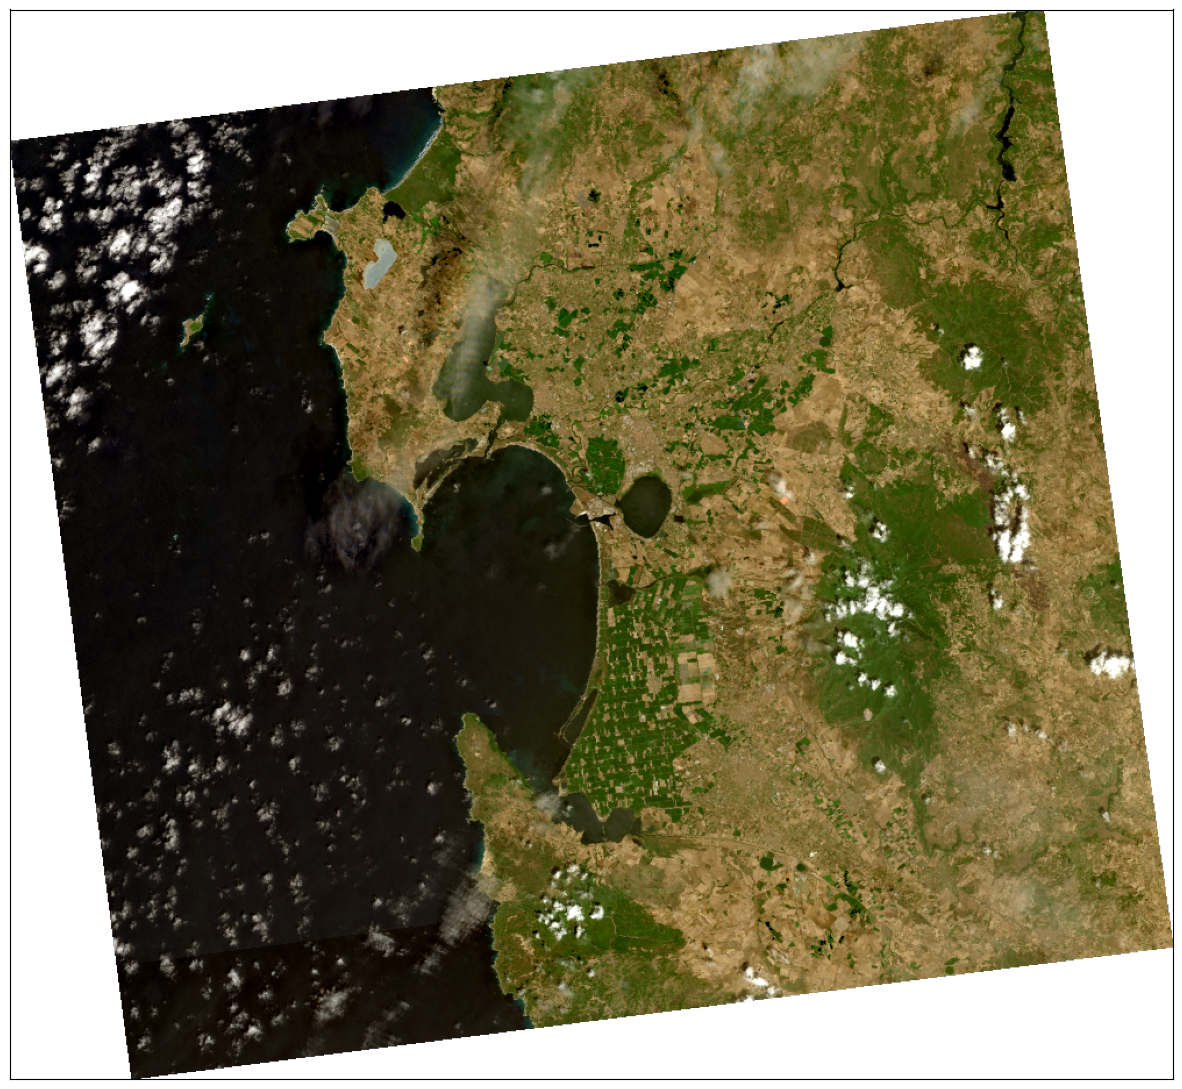

In [ ]:
# Select the first image from the list of images
image = imgs[0]

# Print the data type of the image
print(f"Image type: {image.dtype}")

# Plot the image using the plot_image function
# - factor: Scaling factor for the image values
# - clip_range: Range to clip the image values for display
plot_image(image, factor=1 / 255, clip_range=(0, 1))

In [ ]:
# Define the area of interest as a GeoJSON string
area_of_interest = """
{
  "type": "Polygon",
  "coordinates": [
    [
      [
        8.2000,
        39.6000
      ],
      [
        8.9000,
        39.6000
      ],
      [
        8.9000,
        40.1000
      ],
      [
        8.2000,
        40.1000
      ],
      [
        8.2000,
        39.6000
      ]
    ]
  ]
}
"""

# Read the area of interest into a GeoDataFrame
aoi = gpd.read_file(area_of_interest)

# Simplify the geometry of the area of interest to reduce complexity
aoi_simplified = aoi.geometry.simplify(0.001)

# Update the GeoDataFrame with the simplified geometry
aoi["geometry"] = aoi_simplified

# Calculate the area of the simplified geometry and store it in a new column
aoi["area"] = aoi.area

# Explore the area of interest, coloring it green and without a legend
aoi.explore("area", color="Green", legend=False)

In [ ]:
# Convert the coordinate reference system (CRS) of the area of interest to UTM zone 30N
# and create a Geometry object with the transformed geometry
full_geometry = Geometry(aoi.to_crs(32630).geometry.values[0], crs=CRS.UTM_30N)

In [ ]:
# Define the Evalscript for burn scar detection
evalscript_burn_scar_map = """
//VERSION=3
// Burned area detection
// Author: Monja B. Šebela

function setup() {
    return {
        input: ["B02", "B03", "B04", "B08", "B11", "B12", "dataMask"],
        output: { bands: 4 }
      };
}

function evaluatePixel(samples) {
    // Calculate Normalized Difference Water Index (NDWI)
    var NDWI = index(samples.B03, samples.B08); 
    
    // Calculate Normalized Difference Vegetation Index (NDVI)
    var NDVI = index(samples.B08, samples.B04);
    
    // Calculate a custom index for burned area detection
    var INDEX = ((samples.B11 - samples.B12) / (samples.B11 + samples.B12)) + (samples.B08);

    // Conditional logic to determine burned areas
    if ((INDEX > 0.2) || (samples.B02 > 0.1) || (samples.B11 < 0.1) || (NDVI > 0.3) || (NDWI > 0.1)) {
        // Return RGB values scaled by 2.5 and the data mask
        return [2.5 * samples.B04, 2.5 * samples.B03, 2.5 * samples.B02, samples.dataMask];
    } else {
        // Return red color for burned areas and the data mask
        return [1, 0, 0, samples.dataMask];
    }
}
"""

# Create a SentinelHubRequest for the burn scar map
request_burn_scar_map = SentinelHubRequest(
    evalscript=evalscript_burn_scar_map,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A.define_from(
                name="s2", service_url="https://sh.dataspace.copernicus.eu"
            ),
            time_interval=("2021-07-20", "2021-07-31"),
            other_args={"dataFilter": {"mosaickingOrder": "leastRecent"}},
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    geometry=full_geometry,
    size=[1000, 920],
    config=config,
)

In [ ]:
# Retrieve the burn scar images using the SentinelHubRequest
burn_scar_imgs = request_burn_scar_map.get_data()

In [ ]:
# Print the type and length of the returned burn scar images data
print(
    f"Returned data is of type = {type(burn_scar_imgs)} and length {len(burn_scar_imgs)}."
)

# Print the type and shape of the last element in the burn scar images list
print(
    f"Single element in the list is of type {type(burn_scar_imgs[-1])} and has shape {burn_scar_imgs[-1].shape}"
)

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (920, 1000, 4)


Image type: uint8


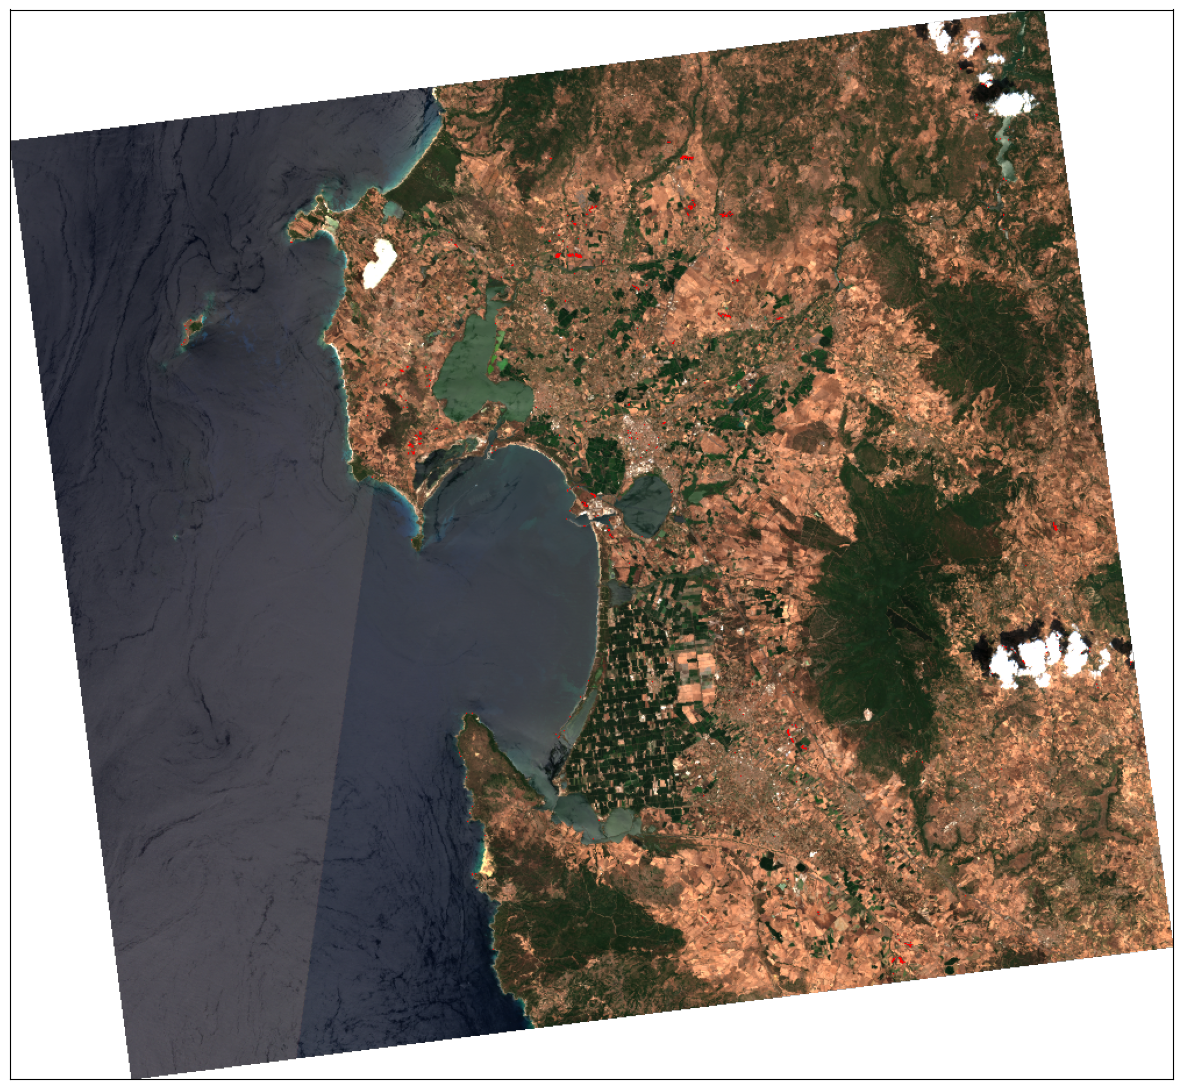

In [ ]:
# Select the first image from the list of burn scar images
image = burn_scar_imgs[0]

# Print the data type of the selected image
print(f"Image type: {image.dtype}")

# Plot the image using the plot_image function
# - factor: Scaling factor for the image values (1.5 / 255)
# - clip_range: Range to clip the image values for display (0 to 1)
plot_image(image, factor=1.5 / 255, clip_range=(0, 1))


<h1>THIS IS THE END OF PART ONE</h1>

----------------------------------------------------------------------

In [ ]:
# General utilities
import getpass  # Module to handle password input securely
import warnings  # Module to manage warnings
from pathlib import Path  # Module to handle filesystem paths
from typing import Any, Optional, Tuple  # Modules for type hinting
import datetime  # Module to handle date and time

# Plotting libraries
import geopandas as gpd  # Library for geospatial data manipulation
import matplotlib.patches as mpatches  # Module for drawing shapes
import matplotlib.pyplot as plt  # Library for creating plots
import numpy as np  # Library for numerical operations
import pandas as pd  # Library for data manipulation and analysis

# Libraries for reading satellite imagery
import rasterio as rio  # Library for reading and writing geospatial raster data
from matplotlib import colors  # Module for handling colors in plots
from rasterio.mask import mask  # Function to mask raster data with shapes
from rasterio.merge import merge  # Function to merge multiple rasters
from rasterio.warp import calculate_default_transform, reproject  # Functions for reprojecting raster data
from rasterio.features import shapes  # Function to extract shapes from raster data
from rasterio.features import sieve  # Function to remove small features from raster data
from rasterio.enums import Resampling  # Enum for resampling methods

# Sentinel Hub services
from sentinelhub import (
    CRS,  # Module for handling coordinate reference systems
    DataCollection,  # Module for defining data collections
    Geometry,  # Module for handling geometric shapes
    MimeType,  # Module for handling MIME types
    SentinelHubRequest,  # Class for creating Sentinel Hub requests
    SentinelHubStatistical,  # Class for statistical requests to Sentinel Hub
    SHConfig,  # Class for Sentinel Hub configuration
    SentinelHubDownloadClient,  # Class for downloading data from Sentinel Hub
)
from shapely.geometry import shape  # Module for geometric operations

# Ignore warnings
warnings.filterwarnings("ignore")

# Enable inline plotting in Jupyter notebooks
%matplotlib inline

In [ ]:
def plot_image(
    image: np.ndarray,
    factor: float = 1.0,
    clip_range: Optional[Tuple[float, float]] = None,
    **kwargs: Any,
) -> None:
    """Utility function for plotting RGB images."""
    # Create a figure and axis for the plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    
    # Plot the image with optional clipping
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    
    # Remove axis ticks
    ax.set_xticks([])
    ax.set_yticks([])


def vectorize_raster(raster_path, vector_path):
    # Open the raster file
    with rio.open(raster_path) as src:
        raster_data = src.read(1)  # Read only the first band
        transform = src.transform  # Get the transform to convert pixel to geographic coordinates
        crs = src.crs  # Get the coordinate reference system

    # Generate shapes from the raster data
    shapes_generator = shapes(raster_data, transform=transform)  # Add mask=raster_data != 0 to exclude nodata values

    # Create a list of vector data with properties and geometry
    vector_data = [
        {"properties": {"value": value}, "geometry": shape}
        for shape, value in shapes_generator
    ]

    # Convert the list of vector data to a GeoDataFrame
    gdf = gpd.GeoDataFrame.from_features(vector_data, crs=crs)
    
    # Save the GeoDataFrame to a file (commented out)
    # gdf.to_file(vector_path, driver="GeoJSON")
    
    return gdf


def reproject_raster(inpath, outpath, crs, method="nearest"):
    "Reproject a raster to a new coordinate system."
    
    dst_crs = f"EPSG:{crs}"  # Define the destination CRS

    # Open the input raster file
    with rio.open(inpath) as src:
        # Calculate the transform, width, and height for the new CRS
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds
        )
        kwargs = src.meta.copy()  # Copy the metadata
        kwargs.update(
            {"crs": dst_crs, "transform": transform, "width": width, "height": height}
        )

        # Open the output raster file and reproject each band
        with rio.open(outpath, "w", **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rio.band(src, i),
                    destination=rio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest,
                )


def write_raster(path, raster, crs, transform, nodata, driver="GTiff"):
    """Write a raster to a file."""
    
    # Open the output raster file and write the data
    with rio.open(
        path,
        "w",
        driver=driver,
        height=raster.shape[0],
        width=raster.shape[1],
        count=1,
        dtype=raster.dtype,
        crs=crs,
        transform=transform,
        nodata=nodata,
    ) as dst:
        dst.write(raster, 1)


# Define functions to extract statistics for all acquisition dates

def extract_stats(date, stat_data):
    d = {}
    for key, value in stat_data["outputs"].items():
        stats = value["bands"]["B0"]["stats"]
        if stats["sampleCount"] == stats["noDataCount"]:
            continue
        else:
            d["date"] = [date]
            for stat_name, stat_value in stats.items():
                if stat_name == "sampleCount" or stat_name == "noDataCount":
                    continue
                else:
                    d[f"{key}_{stat_name}"] = [stat_value]
    return pd.DataFrame(d)


def read_acquisitions_stats(stat_data):
    df_li = []
    for aq in stat_data:
        date = aq["interval"]["from"][:10]
        df_li.append(extract_stats(date, aq))
    return pd.concat(df_li)

In [ ]:
# Define the area of interest as a GeoJSON string
area_of_interest = """
{
  "type": "Polygon",
  "coordinates": [
    [
      [
        8.2000,
        39.6000
      ],
      [
        8.9000,
        39.6000
      ],
      [
        8.9000,
        40.1000
      ],
      [
        8.2000,
        40.1000
      ],
      [
        8.2000,
        39.6000
      ]
    ]
  ]
}
"""

# Read the area of interest into a GeoDataFrame
aoi = gpd.read_file(area_of_interest)

# Set the geometry column to the area of interest
aoi["geometry"] = aoi

# Calculate the area of the geometry and store it in a new column
aoi["area"] = aoi.area

# Explore the area of interest, coloring it green and without a legend
aoi.explore("area", color="Green", legend=False)

In [ ]:
# Define the start and end dates for the time period
start = datetime.datetime(2021, 7, 24)
end = datetime.datetime(2021, 7, 31)

# Define the number of chunks to divide the time period into
n_chunks = 10

# Calculate the time delta for each chunk
tdelta = (end - start) / n_chunks

# Generate the edges of the time windows as ISO format date strings
edges = [(start + i * tdelta).date().isoformat() for i in range(n_chunks)]

# Create time slots as pairs of consecutive edges
slots = [(edges[i], edges[i + 1]) for i in range(len(edges) - 1)]

# Print the time windows
print("Time windows:\n")
for slot in slots:
    print(slot)

Time windows:

('2021-07-24', '2021-07-24')
('2021-07-24', '2021-07-25')
('2021-07-25', '2021-07-26')
('2021-07-26', '2021-07-26')
('2021-07-26', '2021-07-27')
('2021-07-27', '2021-07-28')
('2021-07-28', '2021-07-28')
('2021-07-28', '2021-07-29')
('2021-07-29', '2021-07-30')


In [ ]:
# Convert the coordinate reference system (CRS) of the area of interest to UTM zone 30N
# and create a Geometry object with the transformed geometry
full_geometry = Geometry(aoi.to_crs(32630).geometry.values[0], crs=CRS.UTM_30N)

# Define the Evalscript for creating a SWIR composite
evalscript_swir_composite = """
//VERSION=3
function setup() {
  return {
    input: ["B12","B8A","B04", "dataMask"],
    output: { bands: 4 }
  };
}

function evaluatePixel(sample) {
  return [sample.B12,sample.B8A,sample.B04, sample.dataMask ];
}
"""

# Function to create a SentinelHubRequest for the SWIR composite
def get_swir_composite_request(time_interval):
    return SentinelHubRequest(
        evalscript=evalscript_swir_composite,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A.define_from(
                    name="s2", service_url="https://sh.dataspace.copernicus.eu"
                ),
                time_interval=time_interval,
                other_args={"dataFilter": {"mosaickingOrder": "leastCC"}},
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
        geometry=full_geometry,
        size=[1000, 920],
        config=config,
    )

In [ ]:
# Create a list of SentinelHubRequests for each time slot
list_of_requests = [get_swir_composite_request(slot) for slot in slots]

# Extract the first download item from each request
list_of_requests = [request.download_list[0] for request in list_of_requests]

# Download data using multiple threads
data = SentinelHubDownloadClient(config=config).download(
    list_of_requests, max_threads=5
)

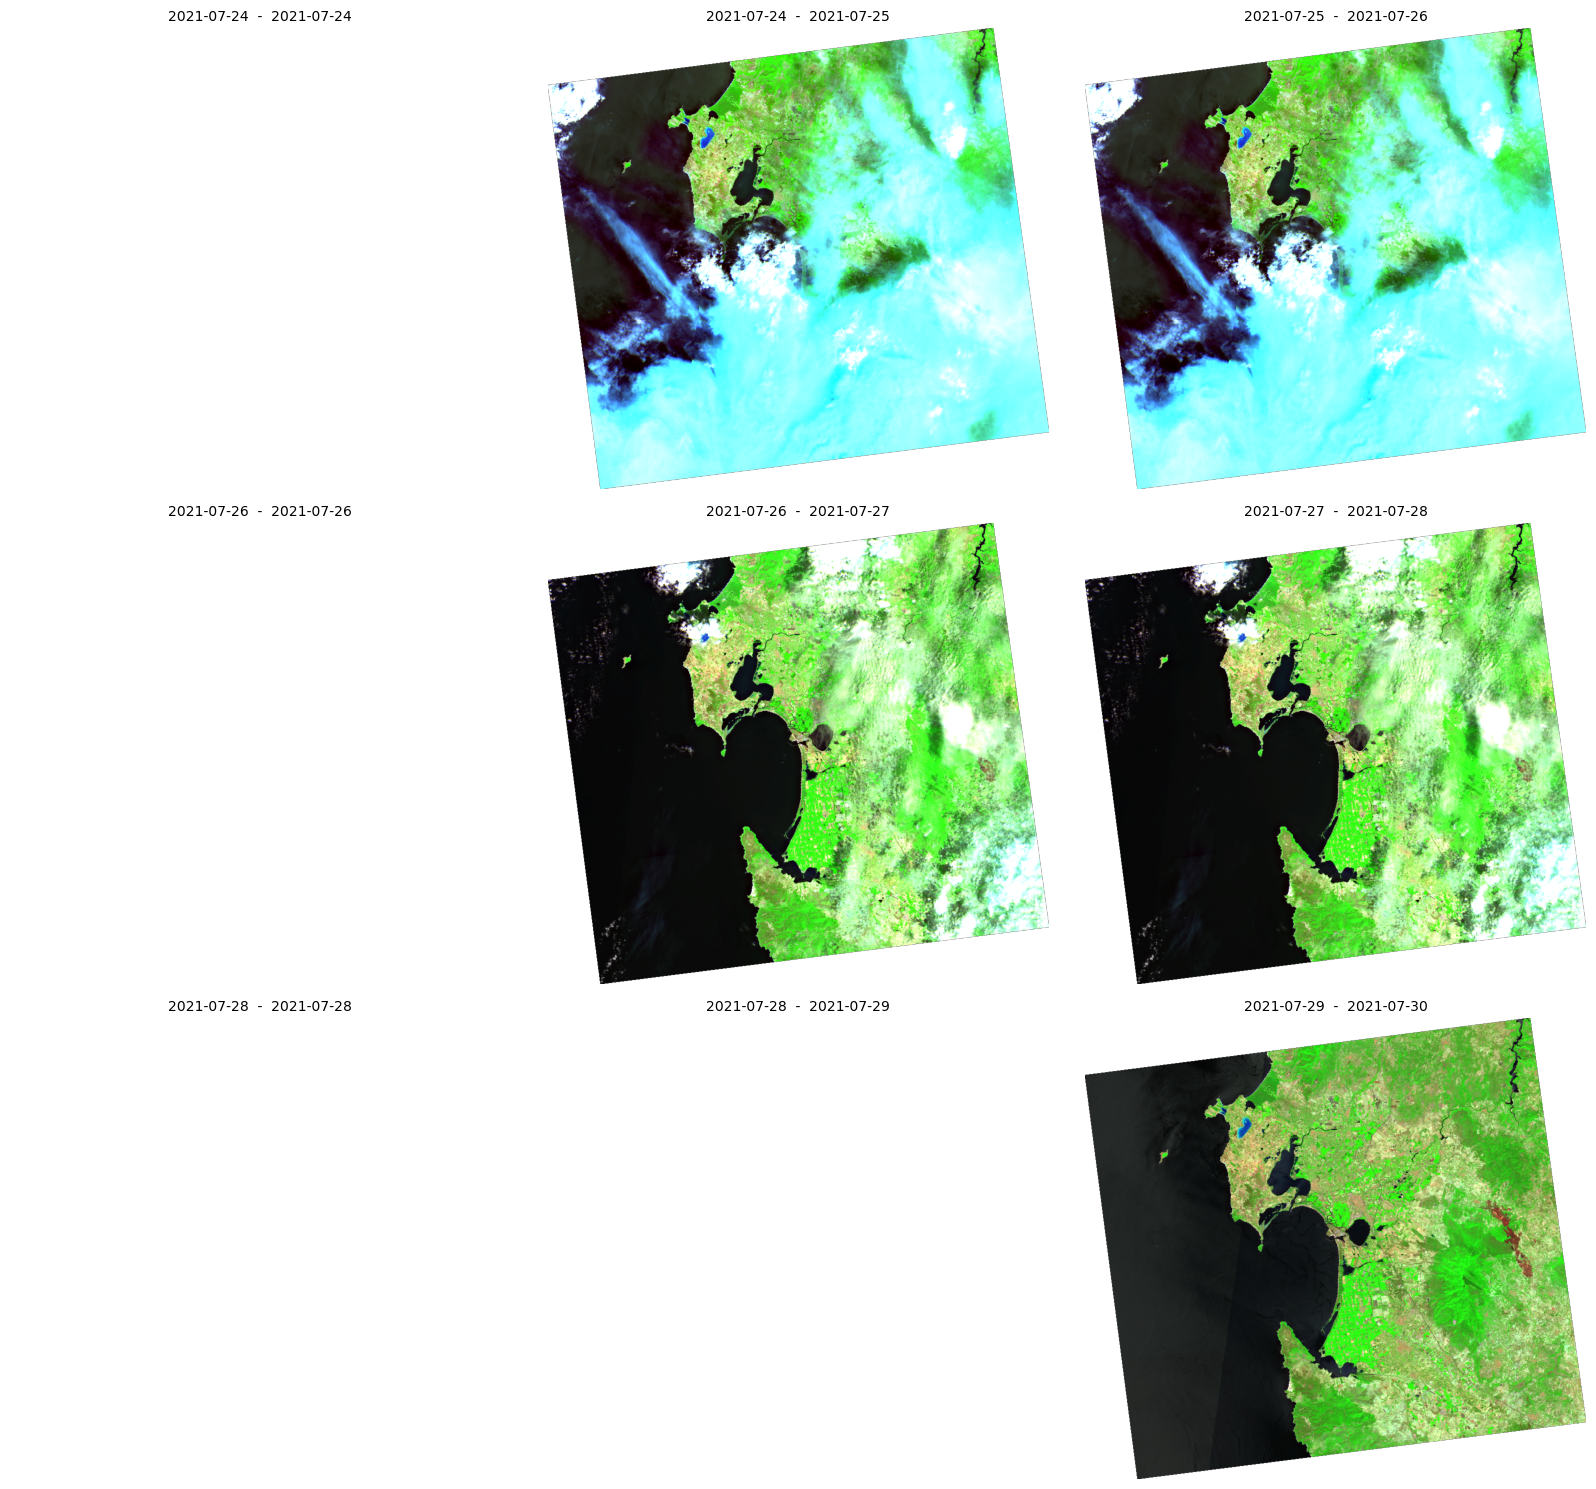

In [ ]:
# Define the number of columns and rows for the subplot grid
ncols = 3
nrows = 3

# Calculate the aspect ratio for the plots
aspect_ratio = 1000 / 920

# Define subplot keyword arguments to remove ticks and frame
subplot_kw = {"xticks": [], "yticks": [], "frame_on": False}

# Create a figure and a grid of subplots
fig, axs = plt.subplots(
    ncols=ncols,
    nrows=nrows,
    figsize=(5 * ncols * aspect_ratio, 5 * nrows),
    subplot_kw=subplot_kw,
)

# Loop through the downloaded images and plot each one
for idx, image in enumerate(data):
    # Determine the position of the subplot
    ax = axs[idx // ncols][idx % ncols]
    
    # Display the image with clipping and scaling
    ax.imshow(np.clip(image * 2.5 / 255, 0, 1))
    
    # Set the title of the subplot to the corresponding time slot
    ax.set_title(f"{slots[idx][0]}  -  {slots[idx][1]}", fontsize=10)

# Adjust the layout to prevent overlap
plt.tight_layout()

In [29]:
# Set the directory where results will be stored
results_dir = "./data"

In [ ]:
# Define the Evalscript for burned area detection
evalscript_burn_scar_detection = """
//VERSION=3
// Burned area detection
// Author: Monja B. Šebela

function setup() {
    return {
        input: ["B02", "B03", "B04", "B08", "B11", "B12", "dataMask"],
        output: { bands: 3, sampleType:"UINT8" }
      };
}

function evaluatePixel(samples) {
    // Calculate Normalized Difference Water Index (NDWI)
    var NDWI = index(samples.B03, samples.B08); 
    
    // Calculate Normalized Difference Vegetation Index (NDVI)
    var NDVI = index(samples.B08, samples.B04);
    
    // Calculate a custom index for burned area detection
    var INDEX = ((samples.B11 - samples.B12) / (samples.B11 + samples.B12)) + (samples.B08);

    // Conditional logic to determine burned areas
    if ((INDEX > 0.2) || (samples.B02 > 0.1) || (samples.B11 < 0.1) || (NDVI > 0.3) || (NDWI > 0.1)) {
        // Return black color for non-burned areas
        return [0, 0, 0];
    } else {
        // Return white color for burned areas
        return [1, 1, 1];
    }
}
"""

# Create a SentinelHubRequest for the burned area detection
request = SentinelHubRequest(
    evalscript=evalscript_burn_scar_detection,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A.define_from(
                name="s2", service_url="https://sh.dataspace.copernicus.eu"
            ),
            time_interval=("2021-07-30", "2021-07-30"),
            other_args={"dataFilter": {"mosaickingOrder": "leastRecent"}},
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    geometry=full_geometry,
    size=[1000, 920],
    data_folder=results_dir,
    config=config,
)

In [ ]:
# Execute the SentinelHubRequest to retrieve the burned area detection data
# and save the data to the specified folder
sh_request = request.get_data(save_data=True)

In [ ]:
# Retrieve the list of filenames for the burned area detection raster data
burn_scar_raster = request.get_filename_list()

In [ ]:
# Open the burned area raster file
burn_scar = rio.open(f"data/%s" % burn_scar_raster[0])

# Clean the burned area raster by removing small features
burn_scar_cleaned = sieve(burn_scar, size=400)

# Save the cleaned raster to a file
write_raster(
    f"{results_dir}/burn_area.tif",
    burn_scar_cleaned.astype("uint8"),
    burn_scar.crs,
    burn_scar.transform,
    0,
)

# Reproject the cleaned raster to EPSG 4326
reproject_raster(
    f"{results_dir}/burn_area.tif",
    f"{results_dir}/burn_area_4326.tif",
    3857,
    method="nearest",
)

# Close the burned area raster file
burn_scar.close()

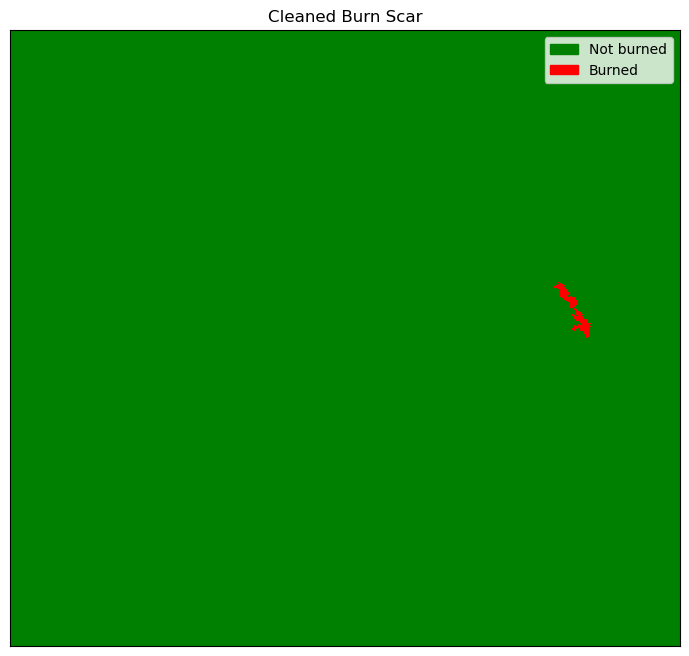

In [ ]:
# Define a colormap for the burn scar visualization
cmap_burn_scar = colors.ListedColormap(["green", "red"])

# Define the boundaries for the colormap
bounds_burn_scar = [0, 0.5, 1]

# Create a normalization object for the colormap
norm_burn_scar = colors.BoundaryNorm(bounds_burn_scar, cmap_burn_scar.N)

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Display the cleaned burn scar raster with the defined colormap and normalization
im = ax.imshow(burn_scar_cleaned, cmap=cmap_burn_scar, norm=norm_burn_scar)

# Remove axis ticks
ax.set_xticks([])
ax.set_yticks([])

# Add a legend to the plot
ax.legend(
    handles=[
        mpatches.Patch(color="green", label="Not burned"),
        mpatches.Patch(color="red", label="Burned"),
    ]
)

# Set the title of the plot
ax.set_title("Cleaned Burn Scar")

# Show the plot
plt.show()

In [ ]:
# Define the path to the reprojected burn area raster file
raster_path = "data/burn_area_4326.tif"

# Define the path to save the vectorized output
vector_path = "data/vectorized.geojson"

# Vectorize the burn scar raster and save the output to the specified path
burn_scar = vectorize_raster(raster_path, vector_path)

In [ ]:
# Print the GeoDataFrame containing the burn scar polygons
print(burn_scar)

# Print a message indicating the goal of extracting points of interest
print("GET THE 4 POINTS OF INTEREST TO SEND THE SWARM OF DRONES TO")

# Iterate through the geometry column of your GeoDataFrame
# for geom in burn_scar.geometry:
#     # Ensure the geometry is a polygon (some GeoDataFrames may have other types)
#     if geom.geom_type == "Polygon":
#         # Print the list of exterior coordinates
#         print(list(geom.exterior.coords))
#         print("************************")

# First, get the total number of polygons in the GeoDataFrame
total_polygons = len(burn_scar.geometry)

# Calculate the 1/4, 2/4, 3/4, and 4/4 indices based on total polygons
index_1 = total_polygons // 4  # 1/4 point
index_2 = total_polygons // 2  # 2/4 point (halfway)
index_3 = 3 * total_polygons // 4  # 3/4 point
index_4 = total_polygons - 1  # 4/4 point (last polygon)

# List of indices we need
required_indices = [index_1, index_2, index_3, index_4]

# Iterate through the geometry column of your GeoDataFrame
for i, geom in enumerate(burn_scar.geometry):
    # Check if the current geometry is a polygon and if the index is one of the required ones
    if geom.geom_type == "Polygon" and i in required_indices:
        # Get the first coordinate of this polygon
        first_coord = list(geom.exterior.coords)[0]
        
        # Print the first coordinate and the polygon number (for clarity)
        print(f"First coordinate of polygon {i+1}: {first_coord}")


                                            geometry  value
0  POLYGON ((980973.317 4846783.771, 980973.317 4...    0.0
1  POLYGON ((980182.583 4847925.943, 980182.583 4...    1.0
2  POLYGON ((982466.927 4843620.833, 982466.927 4...    0.0
3  POLYGON ((981588.333 4842654.379, 981588.333 4...    1.0
4  POLYGON ((981676.193 4842654.379, 981676.193 4...    0.0
5  POLYGON ((983696.959 4841775.785, 983696.959 4...    1.0
6  POLYGON ((983521.24 4841687.926, 983521.24 484...    0.0
7  POLYGON ((983257.662 4840282.176, 983257.662 4...    1.0
8  POLYGON ((981764.052 4844235.848, 981764.052 4...    1.0
9  POLYGON ((903832.772 4890625.607, 903832.772 4...    0.0
GET THE 4 POINTS OF INTEREST TO SEND THE SWARM OF DRONES TO
First coordinate of polygon 3: (982466.9270582523, 4843620.832588585)
First coordinate of polygon 6: (983696.9585351298, 4841775.785373269)
First coordinate of polygon 8: (983257.661579102, 4840282.175722775)
First coordinate of polygon 10: (903832.7719292983, 4890625.606883546)


In [ ]:
# Calculate the area of each polygon in the burn scar GeoDataFrame
burn_scar["area"] = burn_scar.area

# Display the area of each polygon
burn_scar["area"]

# Filter the GeoDataFrame to include only polygons with a value of 1.0 (burned areas)
burn_scar = burn_scar[burn_scar["value"] == 1.0]

# Filter the GeoDataFrame to include only polygons with a non-negative area
burn_scar = burn_scar[burn_scar["area"] >= 0]

# Dissolve the polygons into a single geometry
burn_scar = burn_scar.dissolve()

# Display the resulting GeoDataFrame
burn_scar

geometry  value          area
0  MULTIPOLYGON (((983345.521 4840194.316, 983257...    1.0  3.782444e+06

In [ ]:
# Explore the burn scar GeoDataFrame, coloring the polygons green and displaying a legend
burn_scar.explore("value", color="Green", legend=True)